## Usage examples for `py.ciu.image` package

This code block contains all the `pip install`s that were executed when starting with a (more or less) empty environment. Included mainly FYI. 

In [17]:
# Take care of all requirements. Comment away these if you have already installed as it should already!
#!python3 -m pip install --upgrade pip
#!pip install pandas
#!pip install opencv-python
#!pip install matplotlib
#!pip install tensorflow
#!pip install scikit-image

# These are only needed if you want to develop source files directly in Jupyter Notebook
#!pip install ipython --upgrade 
#%load_ext autoreload 

Do all necessary imports

In [18]:
#%autoreload 2
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from CIU import CIU

In [19]:
from tensorflow import keras
from tensorflow.keras.utils import custom_object_scope
from keras.initializers import glorot_uniform
from keras.preprocessing import image
from keras.applications import inception_v3 as inc_net

### Detecting bleeding in gastro-enterological images

Short example that takes pre-trained model, runs CIU on an image instance and then plots the original image and the image where only superpixels with bleeding detected are shown.
We start by loading model and image to explain, as well as the function for manipulating all images to the format, colors etc expected by the model. 

In [20]:
# Load model and set all needed parameters
with custom_object_scope({'GlorotUniform': glorot_uniform()}):
   model = keras.models.load_model('model_full_categorical.h5')
#model = tf.keras.models.load_model("model_full_categorical.h5")
out_names = ["NonBleeding", "Bleeding"]

# Images should pass through this function before they are given to the model.
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out) / 2 + 0.5

Set up bleeding and non-bleeding images used for testing:

In [21]:
non_bleeding_imgnames = ["Set1_8.png","Set1_153.png","Set1_157.png","Set1_251.png"]
bleeding_imgnames = ["Set1_674.png","Set1_1128.png","Set1_1151.png","Set1_1201.png","Set1_1277.png",
                     "Set1_2812.jpg","Set1_2879.bmp","Set1_3068.bmp","Set1_3078.bmp","Set1_3105.bmp",
                     "Set1_3141.bmp","Set1_3190.bmp"]
imgnames = non_bleeding_imgnames + bleeding_imgnames
imgpath = "images/"
imgpaths = [imgpath + item for item in imgnames]

# Other approach
imgs_vstack = transform_img_fn(imgpaths)

We display all images to see what they look like:

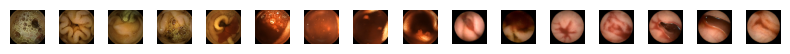

In [22]:
# Plot all images
ncol = len(imgpaths)
fig, axes = plt.subplots(nrows=1, ncols=ncol, figsize=(8, 8))
for i in range(0,len(imgs_vstack)): 
    axes[i].imshow(imgs_vstack[i])
    axes[i].axis('off')
    #axes[i].set_title(imgnames[i])
plt.tight_layout() # Adjust spacing between images
plt.show()

However, that becomes too small when the number of images grows bigger, so let's use grid instead:

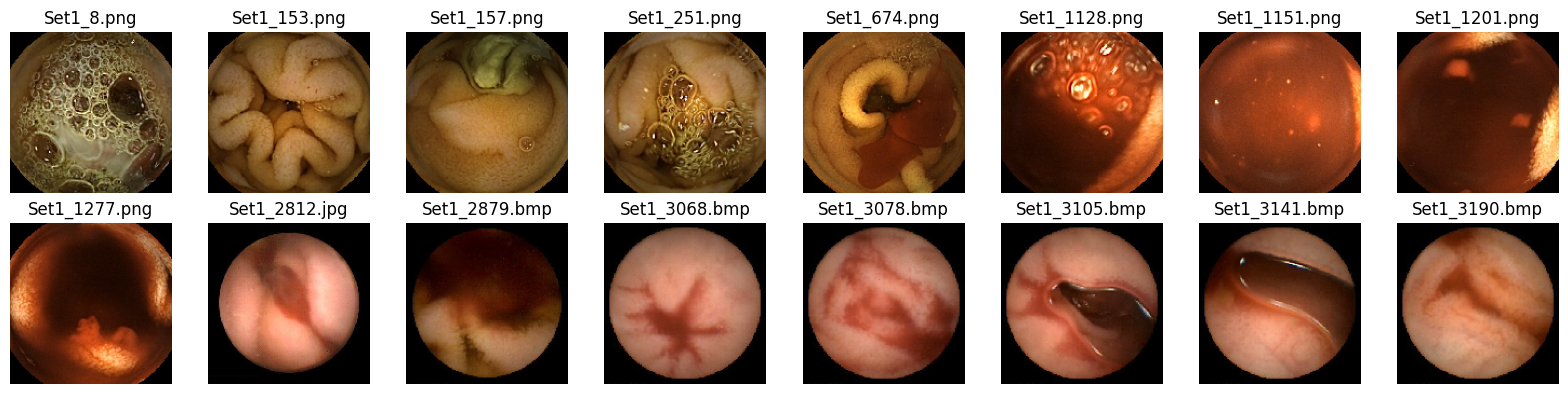

In [23]:
import math

# Define the grid layout
num_images_to_display = len(imgpaths)
num_cols = 8
num_rows = math.ceil(num_images_to_display/num_cols)

# Function for plotting images in a grid
def plotgrid(imgs_vstack, nrows, ncols, figsize=(16,4), figtitles=None):
    total_subplots = nrows * ncols
    n_imgs = len(imgs_vstack)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            if i * ncols + j < n_imgs:
                axs[i,j].imshow(imgs_vstack[i * ncols + j])
                if figtitles is not None:
                    axs[i,j].set_title(figtitles[i * ncols + j])
                axs[i,j].axis('off')
            else:
                axs[i, j].axis('off')  # Turn off empty subplots
    # Remove any excess empty subplots from the display
    for i in range(n_imgs, total_subplots):
        fig.delaxes(axs.flatten()[i])
    plt.tight_layout() # Adjust spacing between images
    plt.show()
    return

plotgrid(imgs_vstack, num_rows, num_cols, figtitles=imgnames)

Let's see what the model predicts for all the images. We set up a "pred_function" to be used later in order to pass to CIU. CIU is model-agnostic so it needs to know how to get the predicted output values from the model.

In [24]:
pred_function = model.predict_on_batch
outvals = pred_function(imgs_vstack)
for ov in outvals: 
    print(f"The model output indicates {out_names[np.argmax(ov)]}")

The model output indicates NonBleeding
The model output indicates NonBleeding
The model output indicates NonBleeding
The model output indicates NonBleeding
The model output indicates Bleeding
The model output indicates Bleeding
The model output indicates Bleeding
The model output indicates Bleeding
The model output indicates Bleeding
The model output indicates Bleeding
The model output indicates Bleeding
The model output indicates Bleeding
The model output indicates Bleeding
The model output indicates Bleeding
The model output indicates Bleeding
The model output indicates Bleeding


If the prediction function is not "predict_on_batch", it can be given as a parameter to ``CIU()``.

Then we create a CIU object and "explain" why a particular image is "Bleeding" or "NonBleeding". A "NonBleeding" explanation would in this case normally contain all or most of the image, except for the black corners. 

For easier interpretation, we also show the original image.

In [25]:
img_to_xplain = 12 # Indices start from zero.
image = imgs_vstack[img_to_xplain]
ciu_object = CIU(model, out_names)
tic = time.perf_counter()
ciu_sp_result = ciu_object.Explain(image)
toc = time.perf_counter()
print(f"Done in {toc - tic:0.4f} seconds")
# Display CI and CU values for "winning" class
winner = np.argmax(ciu_sp_result["outvals"])
print(f"CI values of winner class are:\n {ciu_sp_result['CI'][winner,:]}")
print(f"CU values of winner class are:\n {ciu_sp_result['CU'][winner,:]}")
print(type(ciu_sp_result))

Done in 0.3747 seconds
CI values of winner class are:
 [2.90196397e-07 2.15353634e-06 6.68948414e-05 1.06139542e-11
 9.22657840e-04 1.65945175e-03 2.41130707e-03 1.76193437e-03
 8.14353954e-03 5.22343023e-03 2.80663813e-03 4.14903462e-03
 9.38209007e-04 4.45549347e-04 3.56905861e-03 1.24630146e-03
 9.91014671e-03 4.13534977e-03 6.42348966e-03 1.52537681e-03
 3.12540121e-03 4.83870041e-03 1.34525623e-03 3.13654565e-03
 1.10725351e-02 8.65761787e-02 1.83043897e-03 1.73230872e-01
 1.59318391e-02 8.17001215e-04 1.16928355e-07 3.97971505e-03
 1.02886660e-02 9.79026221e-03 3.40576540e-03 3.87834804e-03
 2.24823952e-02 9.99997556e-01 3.68237868e-03 2.20544660e-03
 2.94126572e-08 3.70148356e-13 2.76785903e-03 3.79605312e-03
 9.45630836e-06 3.16963793e-04]
CU values of winner class are:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
<class 'dict'>


It can be useful to display a histogram of CI values for finding a suitable threshold value:

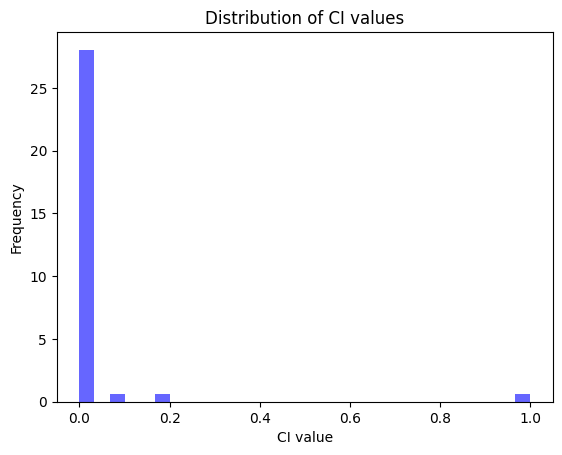

In [26]:
# Create and show histogram plot
CIvals = ciu_sp_result["CI"][winner,:]
plt.hist(CIvals, bins=30, density=True, alpha=0.6, color='b')
plt.xlabel('CI value')
plt.ylabel('Frequency')
plt.title('Distribution of CI values')
plt.show()

Display the corresponding result, together with original image:

The image is Set1_3078.bmp
The model output indicates Bleeding


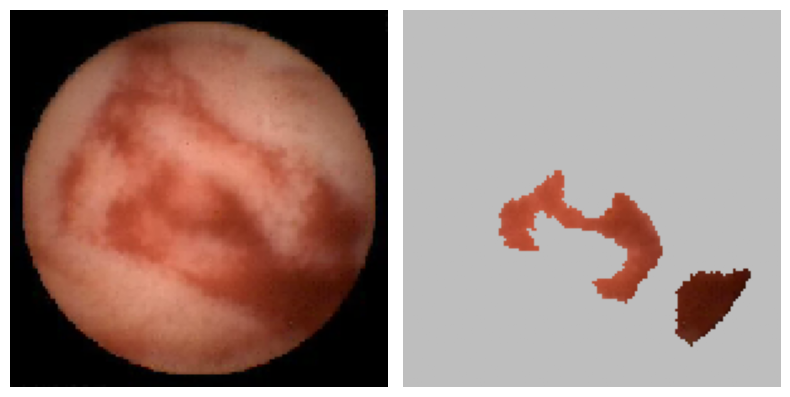

In [29]:
# Include at least one superpixel
max_CI = CIvals.max()
own_CI_limit = 0.5
img = ciu_object.ImageInfluentialSegmentsOnly(winner, min(max_CI, own_CI_limit))
# Commented out the simple display of "explanation image" only
#plt.imshow(img)
#plt.show()
print(f"The image is {imgnames[img_to_xplain]}")
print(f"The model output indicates {out_names[np.argmax(outvals[img_to_xplain])]}")
fig, axes = plt.subplots(1, 2, figsize=(8,8))
axes[0].imshow(imgs_vstack[img_to_xplain])
axes[0].axis('off')
axes[1].imshow(img)
axes[1].axis('off')
plt.tight_layout() # Adjust spacing between images
plt.show()

Get the segments/superpixels and plot their borders:

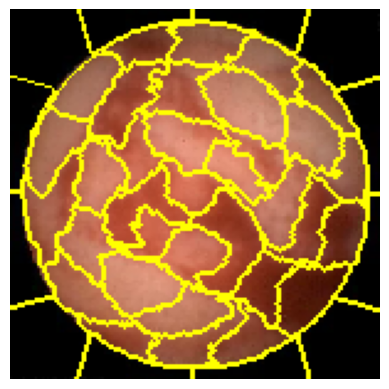

In [30]:
#from scipy import ndimage
from skimage.segmentation import mark_boundaries

# Get the segments
segments = ciu_object.superpixels
num_segments = np.amax(segments)
for i in range(num_segments):
    fig = plt.figure("Superpixels -- %d segments" % num_segments)
    ax = fig.add_subplot(1, 1, 1)
    #ax.imshow(ciu_object.image[0])
    ax.imshow(mark_boundaries(ciu_object.original_image, ciu_object.superpixels))
    plt.axis("off")
plt.show()

Get the explanations for all images:

In [31]:
out_imgs = []
def_CI_limit = 0.5
tic = time.perf_counter()
for i in range(0,len(imgpaths)):
    cius = ciu_object.Explain(imgs_vstack[i])
    win_class = np.argmax(cius["outvals"])
    CI_limit = min(def_CI_limit, cius["CI"][win_class,:].max())
    oimg = ciu_object.ImageInfluentialSegmentsOnly(ind_output=win_class, CI_limit=CI_limit)
    out_imgs.append(oimg)
toc = time.perf_counter()
print(f"Done in {toc - tic:0.4f} seconds")

Done in 4.7085 seconds


Show a grid with all explanations:

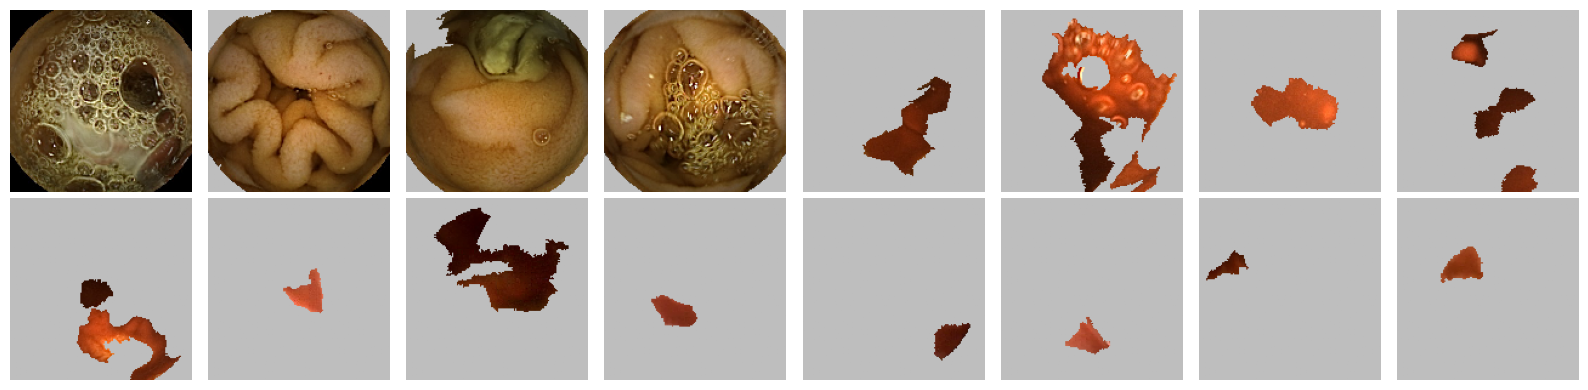

In [32]:
plotgrid(out_imgs, num_rows, num_cols)

Plot original images with names again, for easier comparison. 

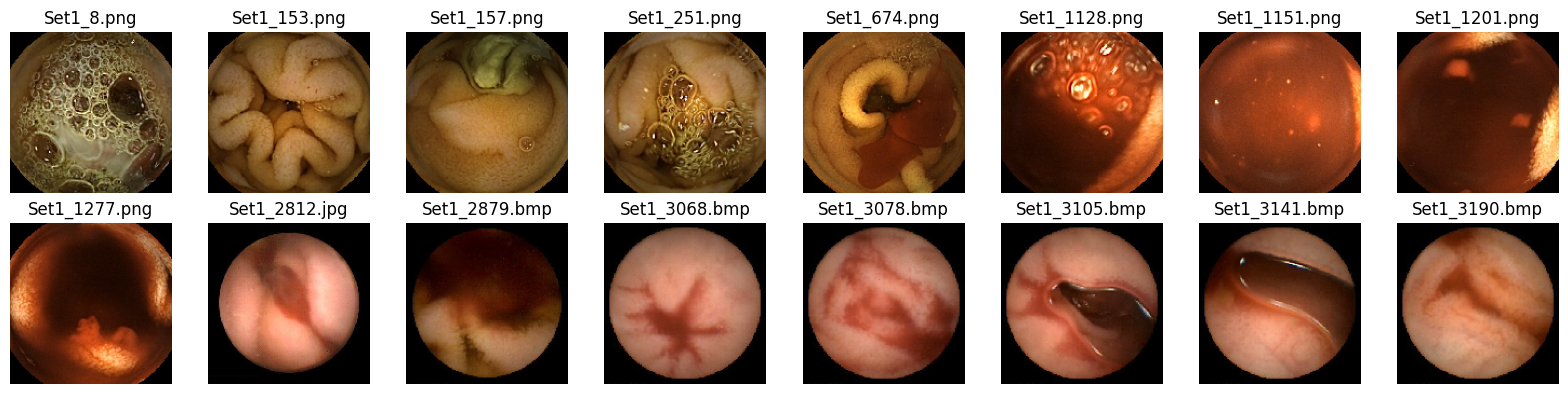

In [33]:
plotgrid(imgs_vstack, num_rows, num_cols, figtitles=imgnames)